#Segunda Entrega Proyecto Final



---



Camilo Andres Silva Rodriguez \\
Juan Jose Caballero Fernandez \\
Javier Santiago Useche Acosta

## retroalimentación 
Es interesante ver cómo han implementado el análisis de causalidad en su proyecto, aunque parece que no profundizan mucho en este aspecto antes de pasar a ARIMA. Sería valioso dedicar más tiempo a explorar y explicar los resultados de este análisis de causalidad, ya que puede ofrecer insights clave sobre las relaciones entre las variables que están estudiando.

En el análisis de la predicción, parece que se ha cometido un error sencillo, pero significativo, en la implementación de la función recursive_forecast_SARIMAX. se estableció los parámetros del modelo como (p, P, q, Q) = (3, 0, 3, 0), d = 1, D = 0 y m = 0 después de un análisis cuidadoso. Sin embargo, en la función de predicción recursiva, se utilizan parámetros diferentes, específicamente  m = 4. aunque es u nerror muy leve deben tener mucho cuidad, porque ha coincidido el resultados 

Con respecto al uso de VAR (Vector AutoRegressive models), es importante considerar los hallazgos previos de su análisis con ARIMA. Si descubrieron que el modelo ARIMA es significativo y depende particularmente de los parámetros q y d, entonces sería apropiado contemplar la aplicación de VARIMA (Vector AutoRegressive Integrated Moving Average) en lugar de un enfoque VAR puro. VARIMA puede proporcionar un marco más completo al incorporar la integración y los promedios móviles en el análisis multivariante, lo que podría ser más adecuado dadas las características de sus series de tiempo.

Además, les recomiendo enfocarse en desarrollar una sección de conclusiones más robusta. Esta sección debería capturar no solo los hallazgos clave de su análisis, sino también interpretar qué significan estos resultados en el contexto más amplio de su estudio. Es fundamental aquí conectar los puntos entre sus análisis


## comentarios de loscompañeros 

Buena escogencia de valores p y q, hubiera sido bueno hacer un forecast.
En general, la estadísitica en práctica está bien, pero encontramos que falta detallar mejor las métricas obtenidas como también detalles de los modelos.
Excelente
Seria bueno comentar más lo que se está desarrollando en cada sección con relación a la solución de la problemática.
Solo implementaron series de tiempo, sería interesante abordar el tema desde otros enfoques.
Todo bien 


##Problemática
Para las personas que invierten en bolsa es importante predecir el valor de la acción de una empresa, en este caso nuestro proyecto tiene cuyo objetivo predecir la variable de la acción de la empresa Shell.

<br>
<br>

##Metodologia
Empezaremos encontrando si la serie es estacional, para lo cual se harán dos cosas, la primera graficar la serie temporal para ver si de alguna manera podemos observar si la serie es estacional o no, también haremos un test Augmented Dickey–Fuller y miraremos si el p-valor es lo suficientemente pequeño, si obtenemos un p-valor grande, diferenciaremos.

Partiremos de un modelo ARIMA donde vamos a predecir el valor de la accion en base a su histórico de ventas, encontraremos los valores apropiados para los parametros del modelo p, d y q, luego de esto miraremos la correlación que hay entre el valor de la acción y el valor del barril de petróleo BRENT para luego evaluar la posibilidad de usar ARIMAX. no descartamos la posibilidad de usar un modelo VAR, para esto realizaremos un test de Granger y ver si una serie temporal depende de la otra, evaluaremos cual modelo hace una mejor predicción.

Cabe resaltar que todos los modelos se seleccionaran dependiendo de cuál tenga el menor valor AIC y de los resultados que se obtengan al realizar validación cruzada, se tomaran en cuenta las métricas MSE y MAE

##Datasets

Los datasets fueron sacados de las siguientes páginas:
<br>
<br>
A continuación está el dataset del histórico de acciones de Shell:
https://finance.yahoo.com/quote/SHEL/history?p=SHEL
<br>
<br>
Dataset, del histórico del petróleo:
https://www.investing.com/commodities/brent-oil-historical-data
<br>
<br>
Cabe aclarar que se tomarán valores desde el 29 de noviembre de 2022 hasta el 24 de noviembre del año 2023

A continuación se realiza el análisis exploratorio de los datos:

# Visualización y Análisis de la Serie Temporal

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Grouper
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm


Primero traemos los datasets, el primero indica el valor de la acción de Shell y la segunda el valor del  barril de petróleo

In [ ]:
dataframe = pd.read_csv('SHEL.csv')

dataframe2 = pd.read_csv('Brent_Oil_Futures_Historical_Data.csv')

In [ ]:
dataframe

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-29,57.270000,58.029999,57.270000,57.619999,55.389149,4289617
1,2022-11-30,58.470001,58.740002,57.856201,58.470001,56.206245,5377406
2,2022-12-01,58.689999,58.770000,57.910000,58.049999,55.802505,4084642
3,2022-12-02,57.720001,58.209999,57.485001,57.720001,55.485283,3510813
4,2022-12-05,58.770000,58.970001,57.105000,57.400002,55.177670,5917006
...,...,...,...,...,...,...,...
246,2023-11-21,66.610001,66.785004,66.345001,66.519997,66.519997,3786288
247,2023-11-22,64.470001,65.535004,64.190002,65.419998,65.419998,6170963
248,2023-11-24,66.160004,66.650002,65.970001,65.989998,65.989998,2036330
249,2023-11-27,66.160004,66.269997,65.665001,65.809998,65.809998,3559317


In [ ]:
dataframe2

,Date,Price,Open,High,Low,Vol.,Change %
0,11/24/2023,80.58,81.40,82.20,80.13,114.14K,-1.03%
1,11/23/2023,81.42,81.60,81.63,80.19,108.32K,-0.66%
2,11/22/2023,81.96,82.47,82.65,78.41,367.18K,-0.59%
3,11/21/2023,82.45,82.13,82.54,81.43,238.51K,0.16%
4,11/20/2023,82.32,80.30,82.94,79.58,248.33K,2.12%
...,...,...,...,...,...,...,...
251,12/05/2022,82.66,85.70,88.20,82.53,193.04K,-3.38%
252,12/02/2022,85.55,86.69,87.68,85.17,141.36K,-1.53%
253,12/01/2022,86.88,86.78,89.37,86.26,229.13K,1.70%
254,11/30/2022,85.43,83.77,85.67,83.61,9.05K,2.89%


ponemos la fecha en formato datatime, esto para llevar la serie de tiempo.

In [ ]:
dataframe['index'] = pd.to_datetime(dataframe['Date'])
dataframe2['index'] = pd.to_datetime(dataframe2['Date'], format='%m/%d/%Y')

dataframe.set_index('index', inplace=True)
dataframe2.set_index('index', inplace=True)

df = dataframe[['Close']]
df2 = dataframe2[['Price']]



In [ ]:
df.dtypes

Close    float64
dtype: object

In [ ]:
df2.columns = ["CloseOil"]

In [ ]:
df_joined = df.join(df2).dropna()

In [ ]:
df_joined

,Close,CloseOil
index,,
2022-11-29,57.619999,83.03
2022-11-30,58.470001,85.43
2022-12-01,58.049999,86.88
2022-12-02,57.720001,85.55
2022-12-05,57.400002,82.66
...,...,...
2023-11-17,65.870003,80.61
2023-11-20,66.680000,82.32
2023-11-21,66.519997,82.45


Observamos la relacion entre ambas variables donde se puede ver una correlación entre estas

In [ ]:
x1 = df_joined['Close']
y = df_joined['CloseOil']

Text(0.5, 1.0, 'Relación entre Close y close oil')

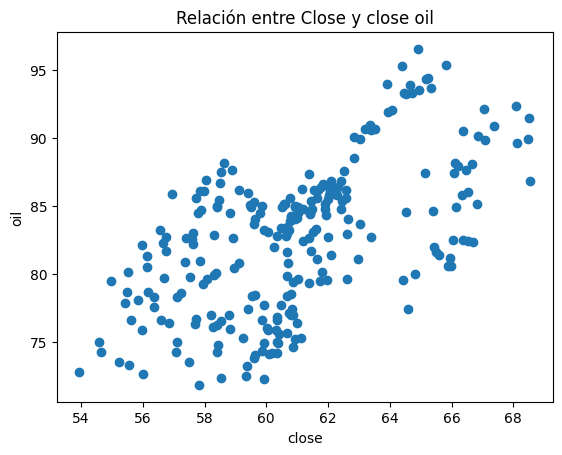

In [ ]:
plt.scatter(x1,y)
plt.xlabel('close')
plt.ylabel('oil')
plt.title('Relación entre Close y close oil')

De igual forma, realizamos un mapa de correlacion entre ambas variables y se comprueba que hay una correlacion lineal de 0.59 entre ambas variables, lo que nos dice que  podríamos evaluar el uso de  ARIMAX.

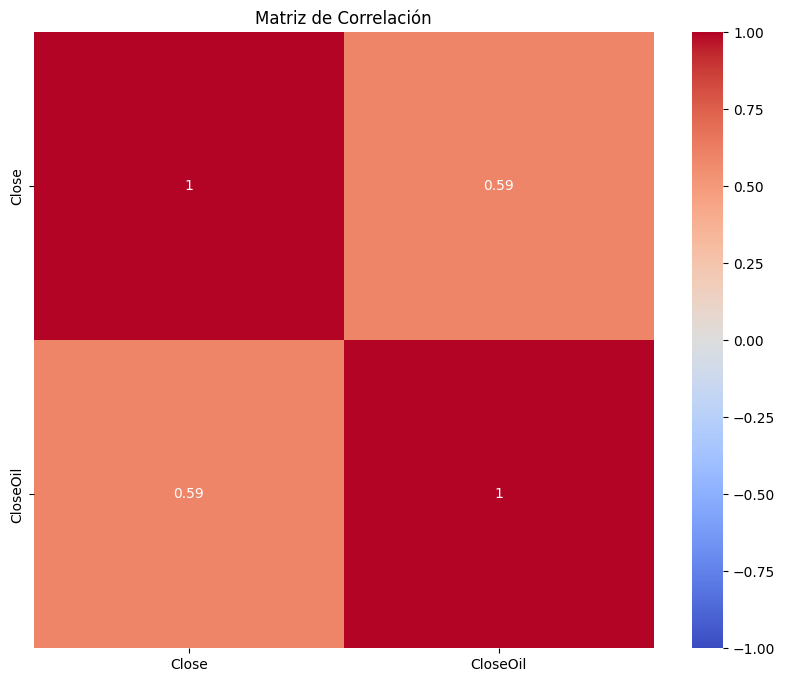

In [ ]:
correlation_matrix = df_joined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:

st = pd.Series(df_joined['Close'], index=dataframe.index).dropna()
st1 = pd.Series(df_joined['CloseOil'], index=dataframe.index).dropna()

Graficamos la linea del tiempo de la accion de SHELL para ver si encontramos estacionalidad y asi encontrar el valor m para un posible modelo SARIMA, pero en este caso no se puede ver, por lo que los valores P, Q, D serán 0 dejándonos con un modelo ARIMA

<Figure size 1500x800 with 0 Axes>

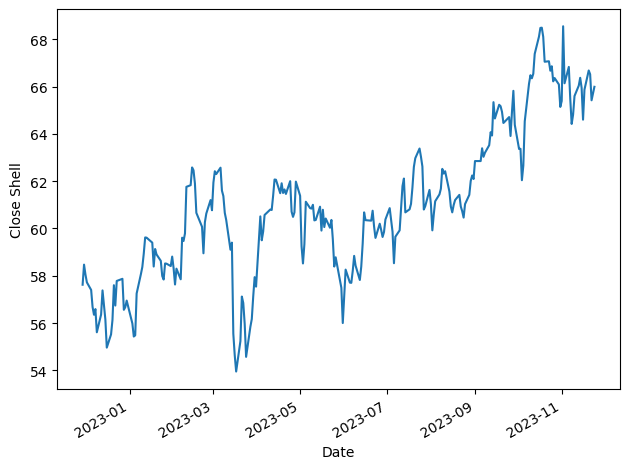

In [ ]:
plt.figure(figsize=(15, 8))
fig, ax = plt.subplots()
st.plot();
ax.set_xlabel('Date')
ax.set_ylabel('Close Shell')

fig.autofmt_xdate()
plt.tight_layout()

# Prueba de estacionariedad

Buscamos saber si es estacionaria la serie de tiempo

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, significance_level=0.05):

    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }



adf_test_results = test_stationarity(st)
adf_test_results

{'ADF Statistic': -1.9613266571679517,
 'p-value': 0.3037830766408637,
 'Critical Values': {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 'Is Stationary (p-value)': False,
 'Is Stationary (ADF)': False,
 'Is Stationary (Both)': False}

Como se puede observar el p-valor es bastante grande, por lo que tendremos que diferenciar

# Estacionalización serie de tiempo
Haremos diferenciación recurrente hasta encontrar un buen valor para nuestro d.

In [ ]:
def make_stationary_recursive(time_series, significance_level=0.05, max_diff=10):
    """
    Estacionaliza una serie de tiempo mediante diferenciación recurrente y
    verifica su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser procesados.
    significance_level (float): El nivel de significancia para la prueba ADF (por defecto es 0.05).
    max_diff (int): El número máximo de diferenciaciones a aplicar.

    Retorna:
    tuple: Una tupla conteniendo el número de diferenciaciones aplicadas (d),
           la serie de tiempo diferenciada y los resultados de la prueba ADF.
    """
    d = 0  # Contador de diferenciaciones
    diff_series = time_series.copy()

    for i in range(max_diff):
        adf_test_results = test_stationarity(diff_series, significance_level)
        if adf_test_results['Is Stationary (Both)']:
            break
        else:
            diff_series = diff_series.diff().dropna()
            d += 1

    return d, diff_series, adf_test_results

Se le realiza una única diferenciación a la gráfica para hacerla estacionaria

In [ ]:
d_count, diff_series, adf_results = make_stationary_recursive(st)
d_count, adf_results

(1,
 {'ADF Statistic': -15.53893724676803,
  'p-value': 2.171884218628422e-28,
  'Critical Values': {'1%': -3.457105309726321,
   '5%': -2.873313676101283,
   '10%': -2.5730443824681606},
  'Is Stationary (p-value)': True,
  'Is Stationary (ADF)': True,
  'Is Stationary (Both)': True})

Ahora buscamos saber si al juntar ambas variables (VAR) es posible sacar un mejor modelo por lo que usamos la prueba de causalidad
de Granger que nos dice si es posible o no.

In [ ]:
print('\nrealdpi Granger-causes realcons?\n')
granger_1 = grangercausalitytests(df_joined[['Close', 'CloseOil']].diff()[1:], [3])

print('realcons Granger-causes realdpi?\n')
granger_1 = grangercausalitytests(df_joined[['CloseOil', 'Close']].diff()[1:], [3])




realdpi Granger-causes realcons?


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9826  , p=0.0320  , df_denom=238, df_num=3
ssr based chi2 test:   chi2=9.2111  , p=0.0266  , df=3
likelihood ratio test: chi2=9.0421  , p=0.0287  , df=3
parameter F test:         F=2.9826  , p=0.0320  , df_denom=238, df_num=3
realcons Granger-causes realdpi?


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6123  , p=0.1872  , df_denom=238, df_num=3
ssr based chi2 test:   chi2=4.9792  , p=0.1733  , df=3
likelihood ratio test: chi2=4.9293  , p=0.1770  , df=3
parameter F test:         F=1.6123  , p=0.1872  , df_denom=238, df_num=3


No todos los p valores son menores a 0.05, tampoco es que sean probabilidades muy grandes, entonces trataremos de usar VAR

#train  test data

In [ ]:
train_size = 192
train_st, test_st = st[:train_size], st[train_size:]
len(train_st), len(test_st)

(192, 57)

## Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)

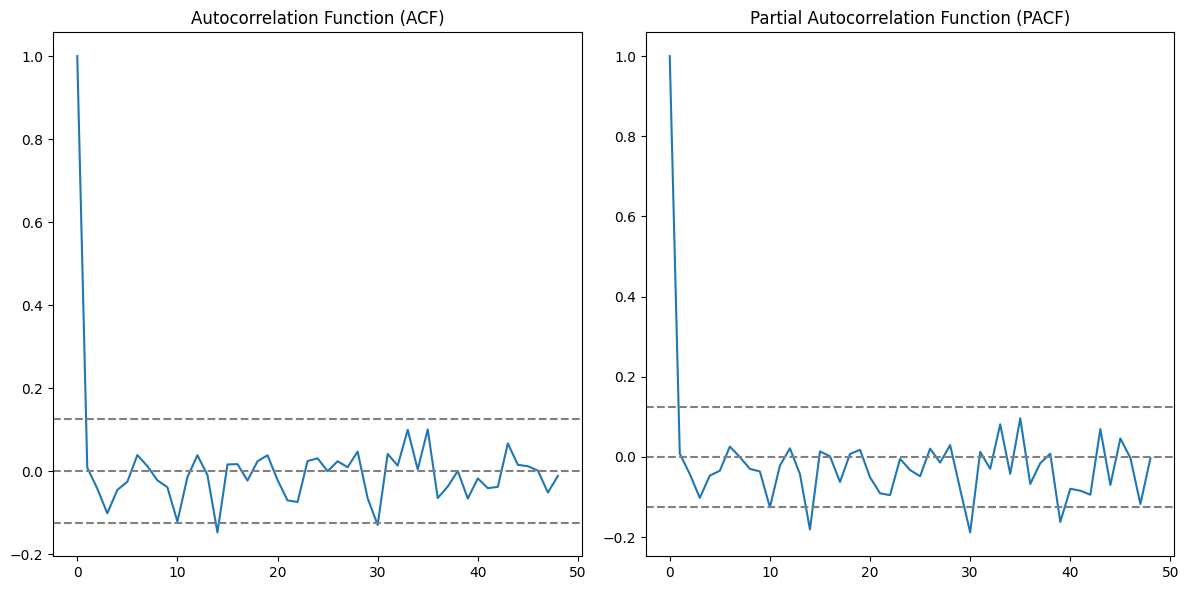

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

if d_count>0:
    train, test = diff_series[:train_size], diff_series[train_size:]


vnlag=min(100, len(train)//4)
lag_acf = acf(diff_series, nlags=vnlag)
lag_pacf = pacf(diff_series, nlags=vnlag, method='ols')

# Plotting ACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

plt.show()



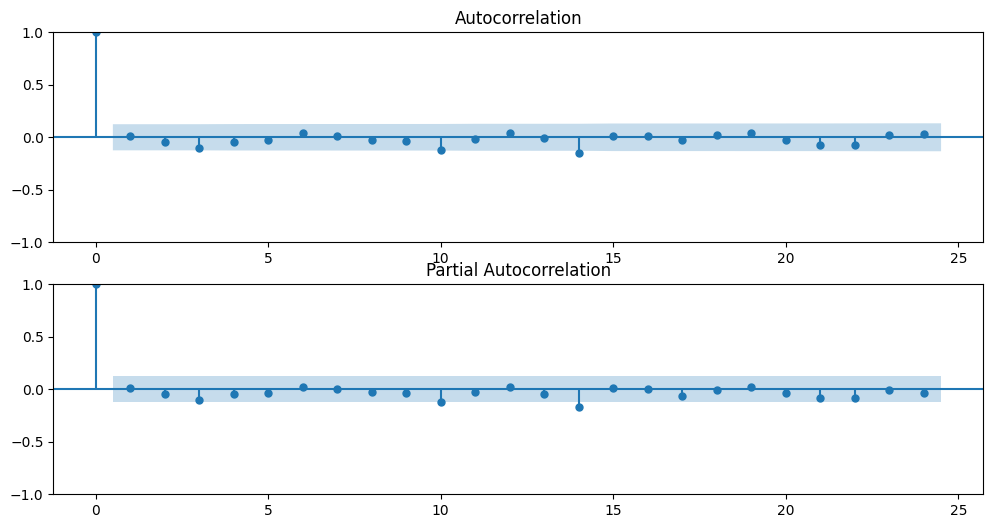

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplots(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_series, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_series, ax=plt.gca())
plt.show()

Basándonos en estos gráficos podemos ver que según el grafico de correlaciones parciales nuestros valores para p serán de 3 10 o 14, los valores para q serán exactamente los mismos

# Modelo ARIMA

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df



## Mejor modelo ARIMA

In [ ]:
ps =[3,10,14]
qs=[3,10,14]
d = 1

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train_st, order_list, d)
print(result_df)

  0%|          | 0/9 [00:00<?, ?it/s]

      (p,q)         AIC
0    (3, 3)  473.465581
1   (10, 3)  483.507087
2   (3, 10)  483.649772
3   (3, 14)  489.693420
4  (10, 10)  492.673154
5   (14, 3)  494.040286
6  (14, 10)  495.524214
7  (10, 14)  496.950618
8  (14, 14)  498.312093


Como podemos observar para valores de p y q de 3, obtenemos el AIC más bajo, procedamos a entrenar un modelo con estos valores

## Ajuste el modelo ARIMA

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  192
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -229.733
Date:                Fri, 01 Dec 2023   AIC                            473.466
Time:                        23:53:33   BIC                            496.231
Sample:                             0   HQIC                           482.687
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7830      0.059     13.305      0.000       0.668       0.898
ar.L2         -0.8179      0.050    -16.386      0.000      -0.916      -0.720
ar.L3          0.8887      0.059     15.097      0.0

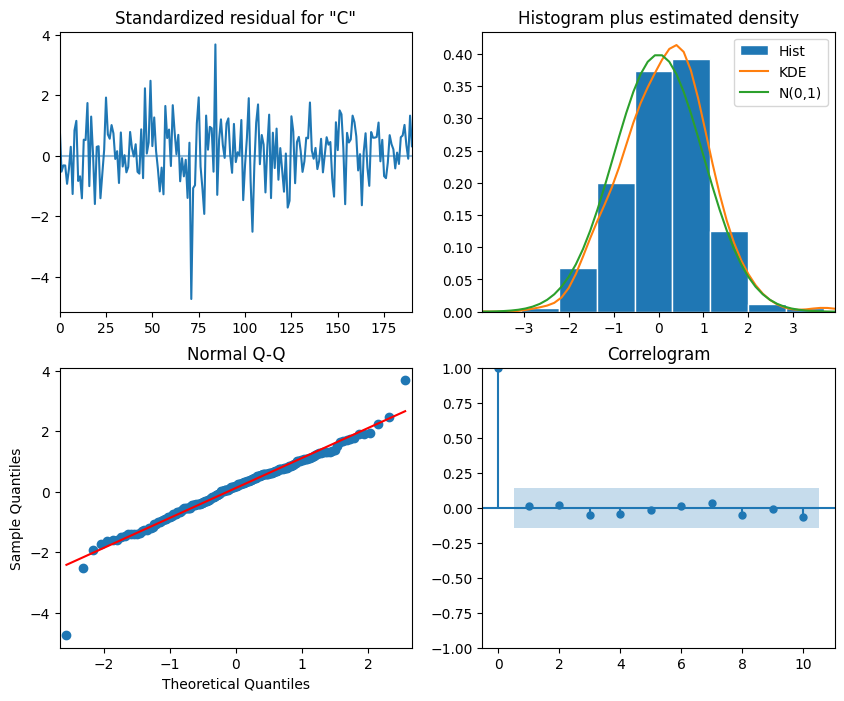

In [ ]:

model = ARIMA(train_st, order=(3, 1, 3))
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8));

Podemos ver que nuestros residuos se pegan a la linea del qqplot, son normales, luego nuestro modelo está explicando bien nuestro dataset, en el correlograma podemos ver que todos nuestros valores caen dentro del intervalo de confianza, la autocorrelación no es significativa

## Rolling forecast

In [ ]:
def rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []
    pred_ARIMA_2 = []

    for i in tqdm_notebook(range(train_len, total_len, window)):
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(window)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [ ]:
TRAIN_LEN = len(train_st)
HORIZON = len(test_st)
WINDOW = 1
pred_ARIMA_st = rolling_forecast(st, TRAIN_LEN, HORIZON, WINDOW, (2,1,8))
fechas = test_st.index
st_pred_ARIMA_st = pd.Series(pred_ARIMA_st[:len(fechas)], index=fechas)

mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse



  0%|          | 0/57 [00:00<?, ?it/s]

0.9021507943287355

### Visualización de las predicciones

0.9021507943287355

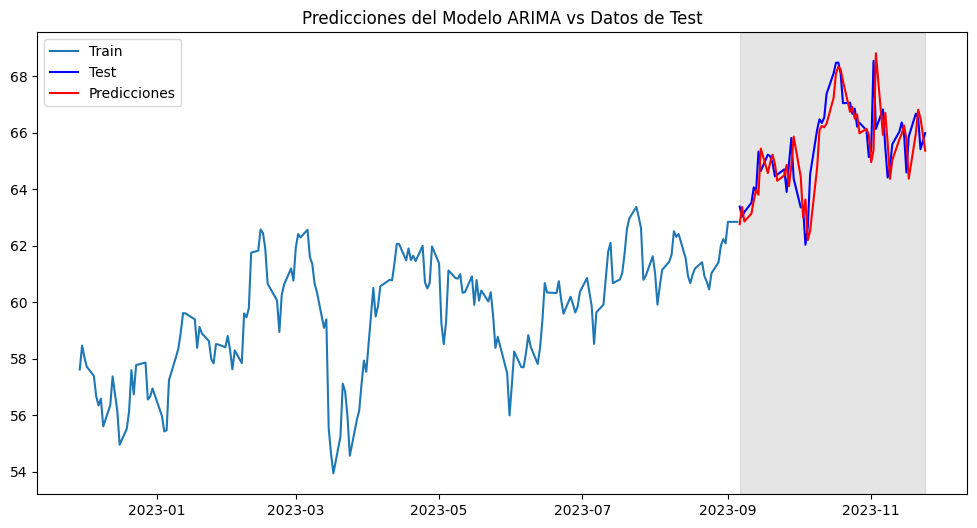

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_ARIMA_st, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test_st, st_pred_ARIMA_st)


mse

In [ ]:
mean_absolute_error(test_st, st_pred_ARIMA_st)

0.7271563945931557

Finalmente podemos observar la prediccion con un mse de 0.90

#Modelo ARIMAX

Como no hay estacionalidad vamos a usar ARIMAX por lo que los valores de D,P,Q y s seran 0

In [ ]:
def optimize_SARIMAX(endog: Union[pd.Series, list],
                     exog: Union[pd.Series, list],
                     order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC',
                                      ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
df_joined

,Close,CloseOil
index,,
2022-11-29,57.619999,83.03
2022-11-30,58.470001,85.43
2022-12-01,58.049999,86.88
2022-12-02,57.720001,85.55
2022-12-05,57.400002,82.66
...,...,...
2023-11-17,65.870003,80.61
2023-11-20,66.680000,82.32
2023-11-21,66.519997,82.45


Note que le agregamos la variable externa close Oil

In [ ]:
target = df_joined['Close']
exog = df_joined[['CloseOil']]
df_joined.info()


target_train = target[:192]
exog_train = exog[:192]


ps =[3,10,14]
qs=[3,10,14]
d = 1
P = [0]
D = 0
Q = [0]
s = 0

parameters = product(ps, qs, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2022-11-29 to 2023-11-24
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     249 non-null    float64
 1   CloseOil  249 non-null    float64
dtypes: float64(2)
memory usage: 13.9 KB


  0%|          | 0/9 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",391.511870
1,"(3, 10, 0, 0)",403.095228
2,"(10, 3, 0, 0)",403.333646
3,"(10, 10, 0, 0)",405.819335
4,"(3, 14, 0, 0)",406.750857
5,"(14, 3, 0, 0)",407.352151
6,"(10, 14, 0, 0)",410.474220
7,"(14, 10, 0, 0)",413.977432
8,"(14, 14, 0, 0)",417.308678


El mejor parametro es 3,3 en p y q

In [ ]:
def recursive_forecast_SARIMAX(endog: Union[pd.Series, list],
                               exog: Union[pd.Series, list],
                               train_len: int, horizon: int, window: int) -> list:

      pred_SARIMAX = []
      total_len = train_len + horizon

      for i in range(train_len, total_len, window):
          model = SARIMAX(endog[:i], exog[:i], order=(3,1,3),
                          seasonal_order=(0,0,0,4), simple_differencing=False)
          res = model.fit(disp=False)
          predictions = res.get_prediction(exog=exog)
          oos_pred = predictions.predicted_mean.iloc[-window:]
          pred_SARIMAX.extend(oos_pred)

      return pred_SARIMAX

In [ ]:
TRAIN_LEN = len(target_train)
HORIZON = len(test_st)
WINDOW = 1
pred_SARIMAX = recursive_forecast_SARIMAX(target, exog, TRAIN_LEN, HORIZON, WINDOW)

fechas = test_st.index
st_pred_SARIMAX = pd.Series(pred_SARIMAX[:len(fechas)], index=fechas)

mse_SARIMAX = mean_squared_error(test_st, st_pred_SARIMAX)


mse_SARIMAX

1.2957152159280858

In [ ]:
mae_SARIMAX = mean_absolute_error(test_st, st_pred_SARIMAX)
mae_SARIMAX

0.7915039693398034

1.2957152159280858

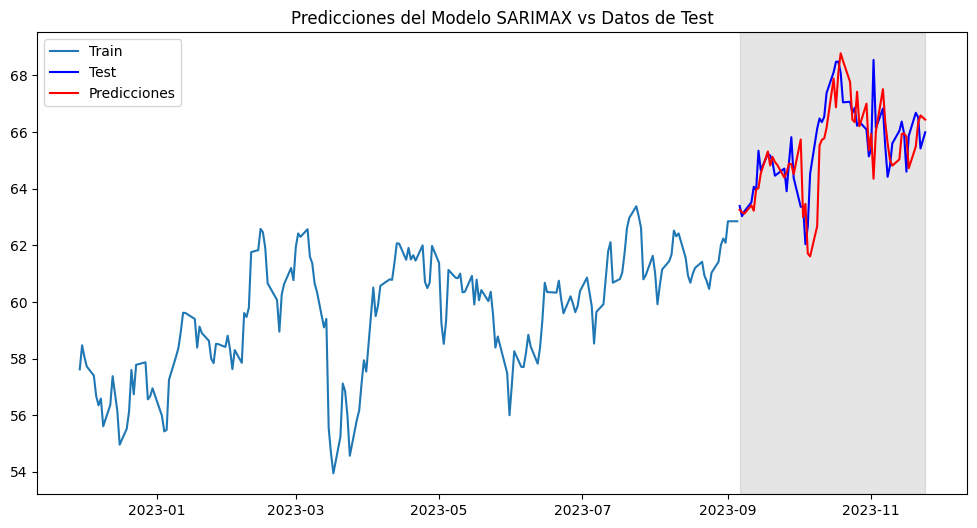

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_SARIMAX, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo SARIMAX vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test_st, st_pred_SARIMAX)


mse

Finalmente tenemos una prediccion peor que la del Arima.

# modelo VAR

Aca vamos a intebtar hacer el modelo Var con ambas variables

In [ ]:
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:

    results = []

    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue

        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

## Mejor Modelo VAR

In [ ]:
endog = df_joined[['Close', 'CloseOil']]

endog_diff = df_joined[['Close', 'CloseOil']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,1,971.338752
1,2,977.713827
2,3,980.313706
3,4,986.982541
4,5,993.323541
5,6,998.071193
6,7,1005.800266
7,8,1008.988761
8,9,1015.811322
9,10,1018.736481


El mejor p es 1

## Ajuste Modelo

                             Statespace Model Results                            
Dep. Variable:     ['Close', 'CloseOil']   No. Observations:                  162
Model:                            VAR(1)   Log Likelihood                -476.669
                             + intercept   AIC                            971.339
Date:                   Fri, 01 Dec 2023   BIC                            999.127
Time:                           23:58:14   HQIC                           982.621
Sample:                                0                                         
                                   - 162                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.00, 0.02   Jarque-Bera (JB):          25.24, 0.29
Prob(Q):                        0.99, 0.88   Prob(JB):                   0.00, 0.86
Heteroskedasticity (H):         0.93, 0.80   Skew:                     -0.24, -0.10
Prob(H) (t

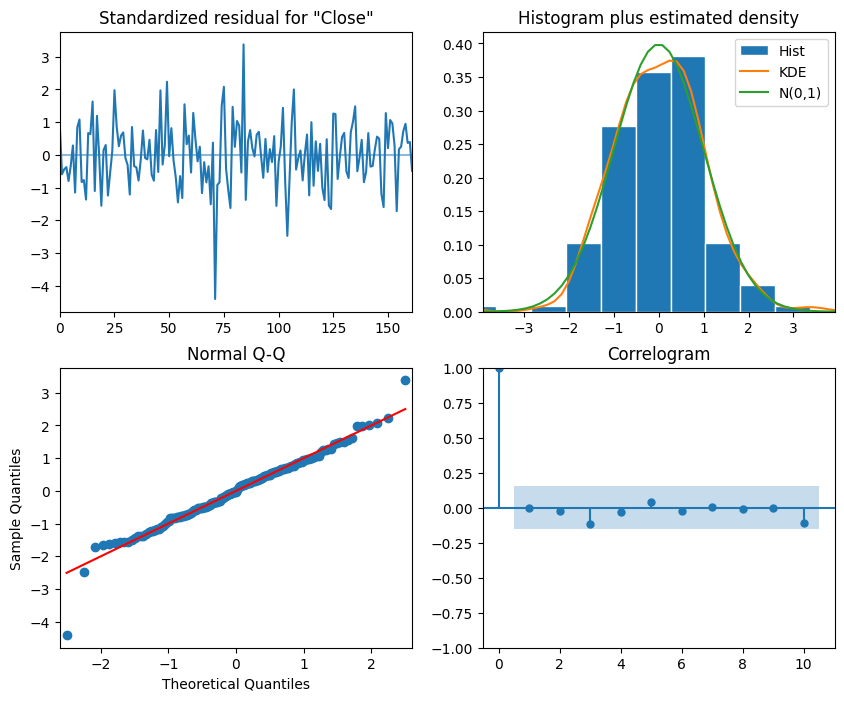

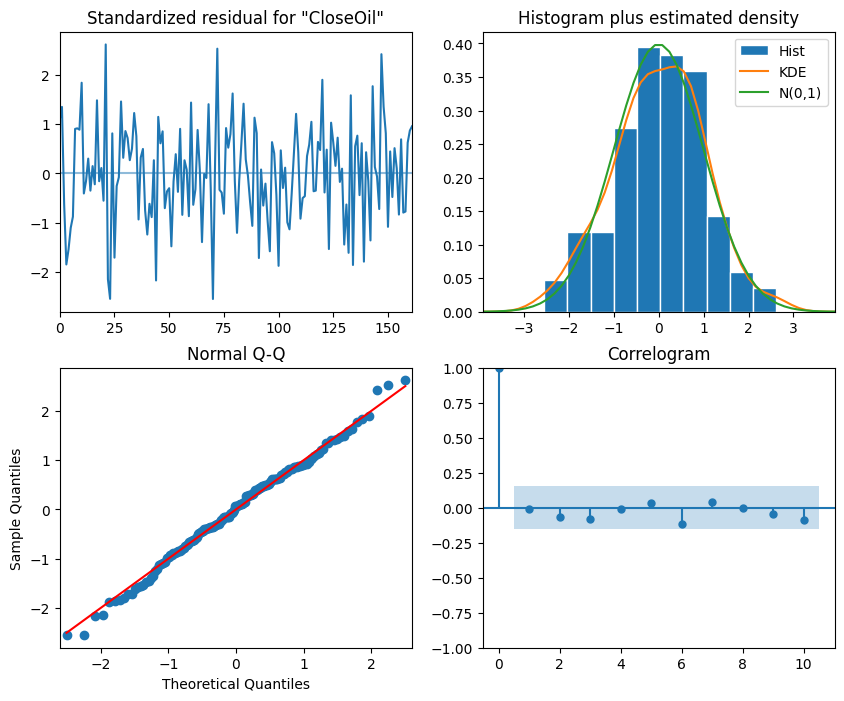

In [ ]:
VAR_model = VARMAX(train, order=(1,0))
VAR_model_fit = VAR_model.fit(disp=False)

print(VAR_model_fit.summary())
VAR_model_fit.plot_diagnostics(figsize=(10,8), variable=0);
VAR_model_fit.plot_diagnostics(figsize=(10,8), variable=1);


## Predicciones

In [ ]:
def rolling_forecast_VAR(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    total_len = train_len + horizon

    realdpi_pred_VAR = []
    realcons_pred_VAR = []

    for i in range(train_len, total_len):
        # Asegúrate de que el índice de inicio y final esté dentro del rango de tus datos
        start_idx = i - train_len
        end_idx = i + horizon

        # Asegúrate de que el rango de fechas para hacer predicciones esté dentro del DataFrame
        if end_idx <= len(df):
            model = VARMAX(df[:end_idx], order=(3, 0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(start=start_idx, end=end_idx - 1)

            # Asegúrate de que las predicciones se extiendan solo hasta el final de tus datos originales
            oos_pred_realdpi = predictions.predicted_mean.iloc[-horizon:]['Close'][:end_idx - start_idx]
            oos_pred_realcons = predictions.predicted_mean.iloc[-horizon:]['CloseOil'][:end_idx - start_idx]

            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)

    return realdpi_pred_VAR, realcons_pred_VAR


Relaizamos las predicciones y les ponemos su variable de tiempo

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realclose_pred_VAR, realcloseoils_pred_VAR = rolling_forecast_VAR(endog_diff, TRAIN_LEN, HORIZON, WINDOW)

print(realclose_pred_VAR)
print(realcloseoils_pred_VAR)

[-0.14237691657321253, -0.16587691812677505, -0.0009827144346271771, 0.10543347547693405, -0.22874186929935847, -0.06974235729961353, 0.017066054556792234, 0.1598373116361564, 0.13828130465459906, -0.2233154346460447, -0.0453037737394471, 0.13488169130614036, -0.11446328385485625, -0.057135844676578354, 0.15975227626817157, 0.008500252663405157, 0.08965977543474446, 0.20616811373037897, 0.1803637186471444, -0.06199416966350853, -0.02847413414106722, 0.09223255259195888, 0.09511913926259097, 0.129277704449771, -0.040692641797707166, -0.07285769768396018, 0.02521138324099217, -0.05863554157161126, -0.009969310905362322, -0.11755552422739136, -0.1717589984857954, -0.16754525018050603, 0.021807218286709056, 0.07154078082303295, -0.037481946995961135, 0.007234255597094341, -0.10454885421441934, 0.004555667109171897, -0.1200249444583802, -0.04413286240375529, -0.00500043107444266, 0.07203997913711183, 0.13027745782686587, 0.036729853348910546, 0.06675144013007818, 0.056911900269680106, -0.19

In [ ]:
# Asegúrate de que las fechas tengan la longitud correcta
date_range = pd.date_range(start=df_joined.index[TRAIN_LEN], periods=len(realclose_pred_VAR))

# Crear DataFrames con las listas y asignar un índice de fechas
df_pred_close = pd.DataFrame({'Close': realclose_pred_VAR}, index=date_range)
df_pred_oil = pd.DataFrame({'CloseOil': realcloseoils_pred_VAR}, index=date_range)

# Mostrar el índice de los DataFrames
print(df_pred_close)
print(df_pred_oil)

               Close
2023-07-25 -0.142377
2023-07-26 -0.165877
2023-07-27 -0.000983
2023-07-28  0.105433
2023-07-29 -0.228742
...              ...
2023-10-14  0.058206
2023-10-15  0.305330
2023-10-16  0.336532
2023-10-17 -0.335904
2023-10-18 -0.117524

[86 rows x 1 columns]
            CloseOil
2023-07-25 -0.402245
2023-07-26 -0.465655
2023-07-27 -0.921279
2023-07-28 -0.229118
2023-07-29 -0.408148
...              ...
2023-10-14 -0.239113
2023-10-15  0.361115
2023-10-16  0.723413
2023-10-17 -0.456235
2023-10-18 -0.582047

[86 rows x 1 columns]


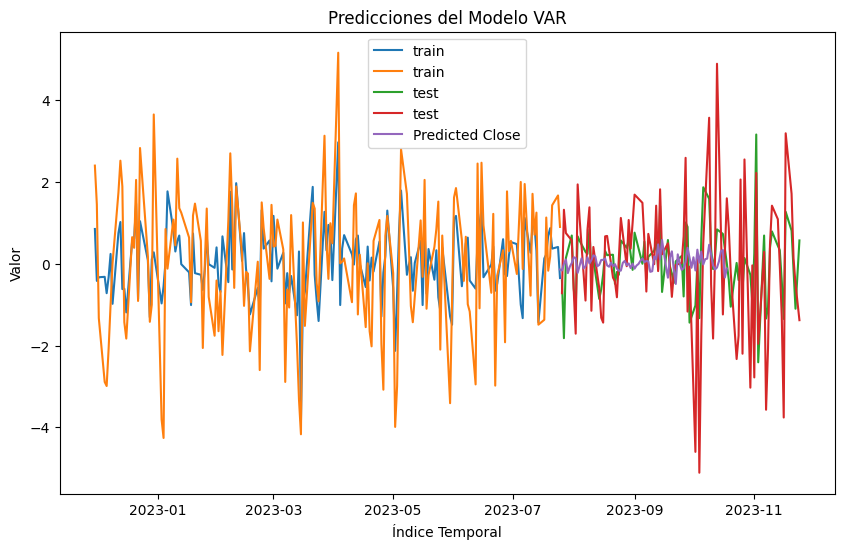

In [ ]:
plt.figure(figsize=(10, 6))

# Graficar las series temporales originales
plt.plot(train, label='train')
plt.plot(test, label='test')

# Graficar las predicciones
plt.plot(df_pred_close, label='Predicted Close')

plt.title('Predicciones del Modelo VAR')
plt.xlabel('Índice Temporal')
plt.ylabel('Valor')
plt.legend()
plt.show()


Aca vemos los errores que tuvieron cada una de las predicciones

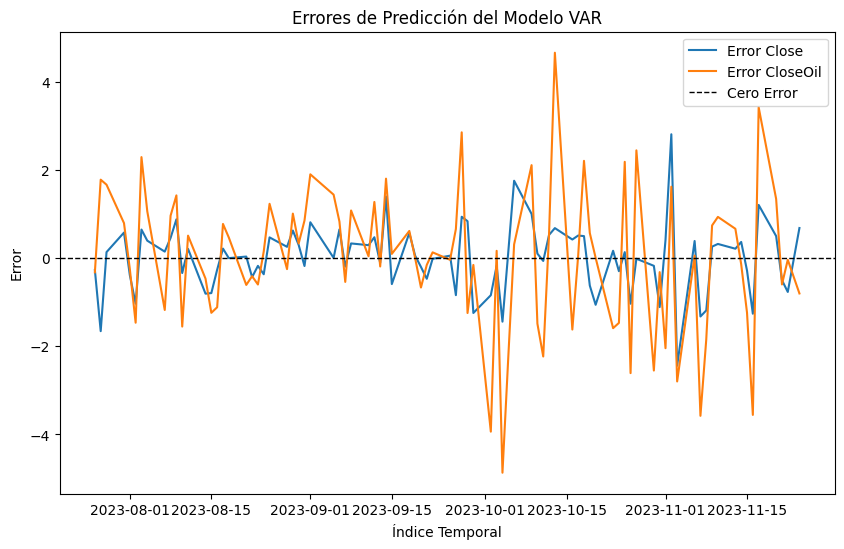

In [ ]:
plt.figure(figsize=(10, 6))

# Calcular y graficar los errores
plt.plot(test['Close'] - realclose_pred_VAR, label='Error Close')
plt.plot(test['CloseOil'] - realcloseoils_pred_VAR, label='Error CloseOil')

plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Cero Error')

plt.title('Errores de Predicción del Modelo VAR')
plt.xlabel('Índice Temporal')
plt.ylabel('Error')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_close = mean_squared_error(test['Close'], realclose_pred_VAR)
mae_close = mean_absolute_error(test['Close'], realclose_pred_VAR)

mse_closeoil = mean_squared_error(test['CloseOil'], realcloseoils_pred_VAR)
mae_closeoil = mean_absolute_error(test['CloseOil'], realcloseoils_pred_VAR)

print(f'MSE Close: {mse_close}, MAE Close: {mae_close}')
print(f'MSE CloseOil: {mse_closeoil}, MAE CloseOil: {mae_closeoil}')


MSE Close: 0.6019534946585722, MAE Close: 0.5806337553240124
MSE CloseOil: 2.68273009769874, MAE CloseOil: 1.2348726927387375


finalmente sacamos el mse y mae viendo que tampoco es mejor que el modelo Arima

Igualmente graficamos para observar que puede predecir ambas variables

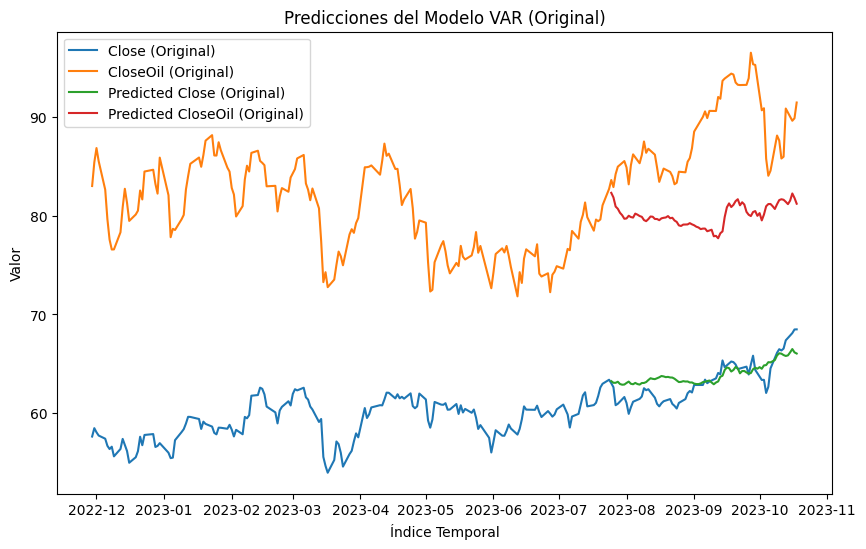

In [ ]:
original_close = df_joined['Close']
original_close_oil = df_joined['CloseOil']

fecha_limite = '2023-10-18'
fecha_limite = pd.to_datetime(fecha_limite)


pred_close_original = original_close.iloc[TRAIN_LEN - 1] + df_pred_close['Close'].cumsum()
pred_close_oil_original = original_close_oil.iloc[TRAIN_LEN - 1] + df_pred_oil['CloseOil'].cumsum()

plt.figure(figsize=(10, 6))

plt.plot(original_close.loc[:fecha_limite], label='Close (Original)')
plt.plot(original_close_oil.loc[:fecha_limite], label='CloseOil (Original)')

plt.plot(pred_close_original, label='Predicted Close (Original)')
plt.plot(pred_close_oil_original, label='Predicted CloseOil (Original)')

plt.title('Predicciones del Modelo VAR (Original)')
plt.xlabel('Índice Temporal')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Concluciones

-El modelo Var no funciono como se esperaba pues a pesar de tener un p-value
 menor de 0.05 en una direccion la otra lo supero lo que hace que la prediccion no sea tan precisam, sin embargo si tambien queremos predecir la variable de petroleo no es una mala decision aplicar este modelo. \\
-Nuestro mejor modelo fue el Arima demostrando que aveces menos es mas y que al realizar mas transformaciones no implica que tengamos un resultado mejor
